# SM03: ETL Pipeline definition

The work completed in the last two posts generally falls under a process called ETL (extract, transform, load). I'm going to roll this work into a single Python script and use it to demonstrate the basics of setting up a SageMaker Pipeline. This will be a pipeline of just one step, but will set the foundation for more complex pipelines.

The bulk of the data cleaning process was written in posts [SM01](https://julielinx.github.io/blog/aws01_read_from_s3/) and [SM02](https://julielinx.github.io/blog/aws02_clean_data/). Most of this code can be put directly into a cohesive `.py` script. Some changes are needed to get the script to run as a Pipeline step. To understand these changes, I need to explain Pipeline foundations first.

## Libraries and usage examples

Unsuprisingly, most of the libraries needed to create a SageMaker Pipeline are found in the `sagemaker` library. I'll only cover the modules needed to run my single step pipeline. Additional modules will be added and explained in future posts as the pipeline becomes more complex.

To get more information on the Amazon SageMaker Python SDK, see [sagemaker.readthedocs](https://sagemaker.readthedocs.io/en/stable/index.html).

### Session and permissions

I've already talked about the first two libraries, they allow me to talk to AWS resources and establish I have premission to use said resources.

#### Libraries

In [ ]:
import sagemaker
import sagemaker.session

#### Parameter examples

In [ ]:
session = sagemaker.session.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()
bucket = session.default_bucket()

### Interactive parameters

SageMaker has the very useful feature of being able to change parameters at runtime. This functionality is extremely useful. I can do things like use the date as a folder name to differentiate between different datasets, then reference the appropriate date at runtime without having to change the pipeline itself.

The `sagemaker.workflow.parameters` module allows me to easily specify these parameters, along with default values to populate the field. There are [four data types](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#pipeline-parameters) that can be defined:

- sagemaker.workflow.parameters.ParameterString – Representing a string parameter
- sagemaker.workflow.parameters.ParameterInteger – Representing an integer parameter
- sagemaker.workflow.parameters.ParameterFloat – Representing a float parameter
- sagemaker.workflow.parameters.ParameterBoolean – Representing a Boolean Python type

Two of the most popular parameters in the [amazon-sagemaker-examples](https://github.com/aws/amazon-sagemaker-examples) repo are the number of instances to spin up and the type(s) of instance(s) to spin up. These two parameters are required when setting up processors and estimators, which is why they're so common.

#### Libraries

In [ ]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString)

#### Parameter examples

In [ ]:
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.m5.xlarge")

### Join text

As a Python user, I'm very familiar and comfortable with both `f'string{param}morestring'` and `'string{}morestring'.format(param)'` when formatting a string. Trying to use these in a SageMaker Pipeline though has me pulling my hair out, because in a lot of situations they don't work. For this, AWS has created the [`Join()` function](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.functions.Join) .

As a rule of thumb, I use `Join()` for any input/output locations, whenever trying to join `sagemaker.workflow.parameters`, or situations in which I need to use a string within the parameter reference.

#### Library

In [ ]:
from sagemaker.workflow.functions import Join

#### Parameter example

In [ ]:
input_uri = Join(on="/", values=['s3://{}'.format(bucket),
                                      prefix,
                                      'raw'])

Join(on="/", values=["s3://{}".format(bucket),
                    prefix,
                    'clean'])

### Processor

My first question when confronted with Proessors was "What *is* a Processor?" The [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html) defines it in a way that every one of my childhood teachers said not to - by referencing the word in the definition: "class `sagemaker.processing.Processor` initializes a Processor instance." The English major in me started crying.

Okay, maybe it wasn't that bad. Looking a little earlier in the text it states that the Processor class is:

> used for Amazon SageMaker Processing Jobs. These jobs let users perform data pre-processing, post-processing, feature engineering, data validation, and model evaluation, and interpretation on Amazon SageMaker.

Practically, the Processor is the instance that executes specified code on defined inputs to produce outputs. It works in conjunction with the ProcessingStep, which defines the input(s) to use and where to save the output(s).

#### Training APIs

As part of a larger whole, processors are part of what SageMaker calls Training APIs. I'll cover each in more detail as it becomes relevant to this series of SageMaker posts. The high level Training APIs include:

- [Analytics](https://sagemaker.readthedocs.io/en/stable/api/training/analytics.html): For tuning job or training job analytics classes
- [AutoML](https://sagemaker.readthedocs.io/en/stable/api/training/automl.html): For creating and interacting with SageMaker AutoML jobs
- [Debugger](https://sagemaker.readthedocs.io/en/stable/api/training/debugger.html): Provides high-level methods to set up Debugger configurations to monitor, profile, and debug your training job
- [Estimators](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html): A high level interface for SageMaker training
- [Algorithm Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/algorithm.html): The Algorithm can be your own, or any Algorithm from AWS Marketplace that you have a valid subscription for. This class will perform client-side validation on all the inputs
- [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html): Defines interaction with Amazon SageMaker hyperparameter tuning jobs
- [Parameters](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html): This is used to define what hyperparameters to tune for an Amazon SageMaker hyperparameter tuning job and to verify hyperparameters for Marketplace Algorithms
- [Processing](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html): These jobs let users perform data pre-processing, post-processing, feature engineering, data validation, and model evaluation, and interpretation on Amazon SageMaker

#### Framework Processors

The base classes aren't the only options for training API type behavior. There are also framework specific classes. The options available with [Amazon SageMaker Processing](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html#data-pre-processing-and-model-evaluation-with-scikit-learn) are:

- [sagemaker.processing.ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor): handles Amazon SageMaker Processing tasks for jobs using a machine learning framework, which allows for providing a script to be run as part of the Processing Job
- [sagemaker.processing.FrameworkProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.FrameworkProcessor): handles Amazon SageMaker Processing tasks for jobs using a machine learning framework, which allows for a set of Python scripts to be run as part of the Processing Job. For frameworks, like TensorFlow, PyTorch, MxNet, etc
- [sagemaker.spark.processing.PySparkProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.spark.processing.PySparkProcessor): handles Amazon SageMaker processing tasks for jobs using SageMaker PySpark
- [sagemaker.spark.processing.SparkJarProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.spark.processing.SparkJarProcessor): handles Amazon SageMaker processing tasks for jobs using Spark with Java or Scala Jars
- [sagemaker.sklearn.processing.SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#sagemaker.sklearn.processing.SKLearnProcessor): handles Amazon SageMaker processing tasks for jobs using scikit-learn

ScriptProcessor and FrameworkProcessor both require an image_uri. An image_uri requires that I specify, build, and register a docker container in ECR (Elastic Container Registery) to handle the task at hand.

PySparkProcessor and SparkJarProcessor require that I specify the framework version (i.e. Spark version) and python version.

SKLearnProcessor is the easiest, in that I only have to specify the framework version. My propensity for using the `pandas` library biases me toward the SKLearnProcessor.

Per the [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/sklearn.html) there are currently three supported framework versions for the SKLearnProcessor:

<table>
    <tr>
        <td><b>Framework Version</b>
            <ul>
                <li>1.0-1</li>
                <li>0.23-1</li>
                <li>0.20.0</li>
            </ul>
        </td>
        <td><b>Minimum Python Version</b>
            <ul>
                <li>3.7</li>
                <li>3.6</li>
                <li>2.7 or 3.4</li>
            </ul>
        </td>
    </tr>
</table>

#### Library

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

#### Processor example

In [ ]:
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="ins-example-job"
)

### Pipeline step

Our first pass at creating a machine learning architecture at my job was to shove all the code into a single, huge repo. Functions and classes were defined individually, then pulled in and referenced in the code that completed the work. Changing any single component tended to have downstream consequences that were very difficult to anticipate.

With the challenges presented by a single, monolith implementation in mind, I decided to pursue more of a microservices architecture when moving to SageMaker. The advantage of this architecutre is to have well devined input/output structures and formats. As long as the input and output followed the definitions, any of the code within the module could be changed with few (or no) downstream consequences.

A step could be considered the same as a microservice. The step defines a piece of work to be done where the inputs and outputs are well defined. The output from one step can then be passed to another step, which has its own well defined inputs and outputs.

#### Step types

There are several types of steps that can be defined in a SageMaker Pipeline. To see the documentation for steps, see [Steps](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#steps) in readthedocs. Here are the different types of steps:

- [Training](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html#API_DescribeTrainingJob_ResponseSyntax)
- [Processing](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html#API_DescribeProcessingJob_ResponseSyntax)
- [Transform](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTransformJob.html#API_DescribeTransformJob_ResponseSyntax)
- Tuning step
    - [Describe hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html#API_DescribeHyperParameterTuningJob_ResponseSyntax)
    - [List training jobs for hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_ListTrainingJobsForHyperParameterTuningJob.html#API_ListTrainingJobsForHyperParameterTuningJob_ResponseSyntax)
- [Create model](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeModel.html#API_DescribeModel_ResponseSyntax)
- [Lambda](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputParameter.html)
- [Call back](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputParameter.html)
- [Quality check](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#qualitycheckstep)
- [Clarify check](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#clarifycheckstep)
- [EMR](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#emrstep)

#### Processing step

The step I'm currently interested in is the ProcessingStep. This step is specifically designed to take input, pass it through a `.py` script designated in the step, and produce output that can be saved and/or passed to subsequent steps. The inputs and outputs are specified in functions designed for that purpose:

- [sagemaker.processing.ProcessingInput](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ProcessingInput): accepts parameters that specify an Amazon S3 input for a processing job and provides a method to turn those parameters into a dictionary
- [sagemaker.processing.ProcessingOutput](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ProcessingOutput): accepts parameters that specify an Amazon S3 output for a processing job and provides a method to turn those parameters into a dictionary

#### Library

In [ ]:
from sagemaker.workflow.steps import ProcessingStep

#### Step example

In [ ]:
step_etl = ProcessingStep(
    name="etl",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_uri, destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(
            output_name="clean",
            source="/opt/ml/processing/output",
            destination=Join(
                on="/",
                values=[
                    "s3://{}".format(bucket),
                    prefix,
                    'clean'
                ]
            )
        )
    ]
    code="etl.py"
)

### Processing input and output

When sending data into and extracting data out of the step, the `ProcessingInput()` and `ProcessingOutput()` functions are required. These functions allow me to specify what to send to the step as input and where to save the output expected to be produced by the step.

The `input` and `output` parameters both require `source` and `destination` variables. Coming from an almost exclusive use of Jupyter Notebooks where I was writing to whatever current directory I happened to be working out of, it took me a hot minute to grasp what `source` and `destination` mean.

- `source`: The location of the existing file or folder
    - Under `input` the `source` is the S3 bucket where the data is stored and waiting to be used
    - Under `output` the `source` is the filepath on the instance where the file or folder to be output is stored
- `destination`: Where to put that file or folder
    - Under `input` the `destination` is the filepath on the instance where the file or folder should be saved
    - Under `output` the `destination` is the S3 bucket where the file or folder to be output is saved

The input and output parameters can accept specific file names or a full folder. For this pipe, I wrote all files to the `raw` folder, then used that folder as my input. SageMaker then writes all of the files in that folder to the `destination`. I only return a single file for the output, but if I wrote multiple files to the folder specified as the `destination`, all of these would be written to the same S3 location as specified in the `destination`.

I like using interactive SageMaker parameters for the `source`. This allows me to specify different datasets while using the same pipeline over and over again. When my model gets stale, I can just point the input at the current dataset and re-train my model using the same setup.

The `destination` is pretty standard. For the most part, it's going to be the default `/opt/ml/processing/input` directory (more on this in the next post). However, occasionaly I need to update it to include subdirectories. I haven't found a reason to create an entirely new directory though.

#### Library

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

#### Example in step

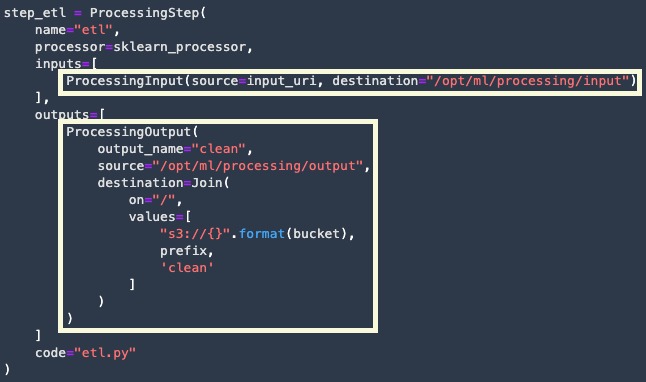

### Pipeline

The final module is to define the Pipeline. I give it a name (which is what shows up under Pipelines in the SageMaker Studio UI), specify the parameters (which are the parameters specified with the `ParameterInteger()` and `ParameterString()` functions that can be defined at runtime), and lists the steps.

The order of the steps in the list doesn't control the flow through the pipeline. Flow is controled through [dependencies between steps](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#step-dependencies). There are two types of step dependencies: 

- data dependency
- custom dependency

I tend to use [data dependency](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#data-dependency-property-reference). This is where I pass the output of one step into a subsequent step, which is done by referencing the step and the `output_name`.

Alternatively, you can specify a custom dependency to make sure that a pipeline execution doesn't start a new step until all dependent steps are complete.

As there is only one step in this pipeline, there is no example of pipeline flow. I'll demonstrate this in a later post.

#### Library

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

#### Pipe example

In [ ]:
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count
    ],
    steps=[step_etl])

## Tags

The only major component not covered while discussing the relevent library modules is tags. Tags are common in enterprise environments. They help associate resources back to specific groups, users, or projects. Being able to specify tags for all the resources spun up in the pipeline is one of my favorite things. Spining up cloud resources in an enterprise environment without tags gets my resources shut down regardless of whether I'm done with them or not.

Tags are specified when loading the pipeline to SageMaker.

In [ ]:
tags = [
    {"Key": "DATASET", "Value": "InsCOIL"},
    {"Key": "SOURCE", "Value": "UCI"}
   ]

## Upload and run pipe

The last piece is to load the pipe and run it. There is a command to just create the pipe, but I prefer `upsert()`. `upsert()` creates the pipe if none exists and replaces the pipe if it already exists. This allows me to adjust my pipeline definition as many times as I want and just overwrite the old, broken code. 

If I had a situation where I didn't want to overwrite a production pipeline (or any non-prod reason I wouldn't want to overwrite), I'd change to use `create()`. To see all the options when using `sagemaker.workflow.pipeline` see the [Pipeline Documents](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#pipeline).

In [ ]:
pipeline.upsert(role_arn=role, tags=tags)

pipeline.start(
    execution_display_name="InsClean")

## Full pipeline code

When all the above information is put together, the final code for the pipeline looks like this:

In [ ]:
import sagemaker
import sagemaker.session

from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString)

from sagemaker.workflow.functions import Join
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.pipeline import Pipeline

session = sagemaker.session.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()

bucket = session.default_bucket()
prefix = '1_ins_dataset'
pipeline_name = "InsExample"  # SageMaker Pipeline name
model_package_group_name = "Insurance Co Example"  # Model name in model registry
framework_version = "0.23-1"

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.t3.medium")

input_uri = Join(on="/", values=['s3://{}'.format(bucket),
                                      prefix,
                                      'raw'])

tags = [
    {"Key": "DATASET", "Value": "InsCOIL"},
    {"Key": "SOURCE", "Value": "UCI"}
   ]

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name="ins-example-job"
)

step_etl = ProcessingStep(
    name="etl",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_uri, destination="/opt/ml/processing/input")
    ],
    outputs=[
        ProcessingOutput(
            output_name="clean",
            source="/opt/ml/processing/output",
            destination=Join(
                on="/",
                values=[
                    "s3://{}".format(bucket),
                    prefix,
                    'clean'
                ]
            )
        )
    ],
    code="etl.py"
)

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count
    ],
    steps=[step_etl])

pipeline.upsert(role_arn=role, tags=tags)

pipeline.start(
    execution_display_name="InsClean")

## Next steps

Running this code before creating the `.py` to run won't do me any good. I need to define the `etl.py` script and make sure it's written to the expected folder. I'll discuss how to write this code in the next post.